In [24]:
import sys
import pickle
import time
from matplotlib import collections
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

main_dir = ''
func_dir = main_dir + 'utils/'
fig_dir = main_dir + 'results/paper_figures/'

sys.path.insert(0,func_dir)

import mouse_data_functions as cs
from ridge_regression_functions import get_best_alpha_evars
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice, get_evars_all_mice
from macaque_data_functions import get_get_condition_type, get_resps, get_img_resp_avg_sem
from fig_7_functions import trial_randomize, make_mouse_df_time, add_stars_2_sets,plot_null_line, make_monkey_df_time
from neuron_properties_functions import extract_mouse_name
from ridge_regression_functions import get_predictions_evars_parallel
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates,get_max_corr_vals_monkey_all_dates,get_evar_monkey_all_dates,get_one_vs_rest_r_monkey_all_dates, store_macaque_alphas





## Mouse Shuffle Trial Repeats

### coding

In [6]:
mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

#get inter-area predictability 
get_evars_all_mice(main_dir, mouse_stats)
get_evars_all_mice(main_dir, mouse_stats, control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)


seed = 17
dataset_types = ['ori32','natimg32']
area='L23'
area2='L4'
activity_type = 'resp'
n_splits=10
sample_size=500



start_time = time.time()

for d, dataset_type in enumerate(dataset_types):
    mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
    mousenames= sorted(mt.filenames)
    for mouse in mousenames:
        
        resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity(activity_type, mouse)
        if len(resp_L1)<1000:
            continue
        istim = mt.istim
        
        alpha = mouse_stats['mouse_alphas'][sample_size][(extract_mouse_name(mouse))][area]
        alpha2 = mouse_stats['mouse_alphas'][sample_size][(extract_mouse_name(mouse))][area2]
        
        if mouse_stats['mouse_alphas'][sample_size][(extract_mouse_name(mouse))]['dataset_type_used']==dataset_type:
                resp_L23=resp_L23[sample_size:]
                resp_L4=resp_L4[sample_size:]
                istim = istim[sample_size:]
                
        
        shuffled_istim_indices = trial_randomize(istim=istim, seed=seed)
        
        
        _, evars = get_predictions_evars_parallel(resp_L4[shuffled_istim_indices], 
                                                    resp_L23, n_splits=n_splits, alpha=alpha, 
                                                    frames_reduced=5)
        _, evars2 = get_predictions_evars_parallel(resp_L23[shuffled_istim_indices], 
                                                    resp_L4, n_splits=n_splits, alpha=alpha2, 
                                                    frames_reduced=5)
        mouse_stats[dataset_type][mouse][area]['shuffled_istim_indices']=shuffled_istim_indices
        mouse_stats[dataset_type][mouse][area2]['shuffled_istim_indices']=shuffled_istim_indices

        mouse_stats[dataset_type][mouse][area]['evar_shuffled_istims']=evars
        mouse_stats[dataset_type][mouse][area2]['evar_shuffled_istims']=evars2
        print(mouse, 'done')
end_time = time.time()
# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60
print(f'yay! all is completed')
print(f'Took {elapsed_time:.4f} minutes to complete')


ori32_M160825_MP027_2016-12-15 done


/Users/diannahidalgo/Documents/thesis_shenanigans/aim2_project/inter_areal_predictability_local/utils/ridge_regression_functions.py:165: RuntimeWarning: Mean of empty slice
  return sorted_preds, np.nanmean(np.array(split_evars), axis=0)
/Users/diannahidalgo/Documents/thesis_shenanigans/aim2_project/inter_areal_predictability_local/utils/ridge_regression_functions.py:165: RuntimeWarning: Mean of empty slice
  return sorted_preds, np.nanmean(np.array(split_evars), axis=0)


ori32_M170604_MP031_2017-06-26 done
ori32_M170714_MP032_2017-08-02 done
ori32_M170717_MP033_2017-08-17 done


/Users/diannahidalgo/Documents/thesis_shenanigans/aim2_project/inter_areal_predictability_local/utils/ridge_regression_functions.py:165: RuntimeWarning: Mean of empty slice
  return sorted_preds, np.nanmean(np.array(split_evars), axis=0)
/Users/diannahidalgo/Documents/thesis_shenanigans/aim2_project/inter_areal_predictability_local/utils/ridge_regression_functions.py:165: RuntimeWarning: Mean of empty slice
  return sorted_preds, np.nanmean(np.array(split_evars), axis=0)


natimg32_M170604_MP031_2017-06-27 done
natimg32_M170714_MP032_2017-08-01 done
natimg32_M170717_MP033_2017-08-25 done
yay! all is completed
Took 1.6231 minutes to complete


### plotting

In [7]:
df_mouse_all = make_mouse_df_time(mouse_stats)
df_mouse=df_mouse_all[(df_mouse_all['SNR']>2)&(df_mouse_all['split-half r']>0.8)&(df_mouse_all['control_shuffle']==False)]
df_mouse_null=df_mouse_all[(df_mouse_all['SNR']>2)&(df_mouse_all['split-half r']>0.8)&(df_mouse_all['control_shuffle']==True)]
melted_mouse_df = df_mouse.melt(id_vars=['Dataset Type', 'Activity Type', 'Mouse', 'Mouse Name', 'Area',
       'Direction', 'SNR', 'split-half r', 'max r² val', '1-vs-rest r²',
       'control_shuffle', 'Neuron',],
                                        value_vars=['EV', 'EV shuffled'],
                                        var_name='Shuffle Type',
                                        value_name='EV fraction')


In [8]:
order=['L4→L2/3', 'L2/3→L4']
hue_order = ['EV', 'EV shuffled']
x='Direction'
y='EV fraction'
hue='Shuffle Type'

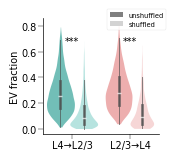

In [9]:
fontsize=7
fig, ax = plt.subplots(figsize=(1.5,1.5))
sns.violinplot(data=melted_mouse_df, x=x, y=y, 
            hue=hue, order=order,hue_order=hue_order,
            linewidth=0, gap=-0.2, width=0.8, inner='box', palette=['gray','lightgray'],
            inner_kws={'box_width':2, 'alpha':0.7, 'markersize':3, 'markeredgewidth':1},
            saturation=1,cut=0)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=handles, labels=['unshuffled', 'shuffled'], fontsize=6*0.8, loc=(0.55,0.9))
legend.get_frame().set_linewidth(0.2)
ax.tick_params(axis='both', labelsize=fontsize, pad=1, width=0.3)
ax.set_xlabel(None)
ax.set_ylabel(y, fontsize=fontsize, labelpad=1)
sns.despine()

custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE', '#f6d6d6']
violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
for violin, color in zip(violins, custom_colors):
    violin.set_facecolor(color)
ax.spines[:].set_linewidth(0.5)

add_stars_2_sets(melted_mouse_df, neuron_property=y, 
hue=hue, ax=ax, fontsize=fontsize,x=x, x_order=order,height1=0.8, height2=0.8, perm_type='paired', hierarchical=True)
plot_null_line(df_mouse_null, neuron_property='EV', ax=ax)
plt.show()

In [12]:
df_mouse_ = make_mouse_df_time(mouse_stats).query('control_shuffle==False')[['Dataset Type', 'Mouse', 'Mouse Name', 'Area', 'Direction', 'EV','1-vs-rest r²',
       'Neuron', 'EV shuffled', 'Activity Type']]
df_mouse_spont = make_mouse_df_time(mouse_stats, dataset_types=['ori32_spont','natimg32_spont']).query('control_shuffle==False')[['Dataset Type', 'Mouse', 'Mouse Name', 'Area', 'Direction', 'EV','1-vs-rest r²',
       'Neuron', 'EV shuffled', 'Activity Type']]
df_mouse_spont_ =df_mouse_spont.rename(columns={'EV':'EV gray screen','EV shuffled':'EV shuffled gray screen' })
df_mouse_resp_spont = pd.merge(df_mouse_, df_mouse_spont_, on=['Mouse', 'Mouse Name', 'Area', 'Direction','1-vs-rest r²',
       'Neuron'])
df_mouse_resp_spont_sorted = df_mouse_resp_spont.sort_values('EV gray screen')

In [13]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
colors = ['#ddf2f0', '#55C0B7', '#112624']
norm = Normalize(vmin=0, vmax=1)
v4_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
colors = ['#FFE8E8', '#F58B8E', '#551312']
v1_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

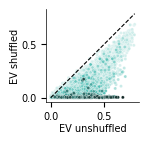

In [14]:
area='L2/3'
palette=v4_cmap

fontsize=7
line_color='black'
x= 'EV'
y='EV shuffled'
hue='EV gray screen'

fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area],
x=x, y=y, hue=hue, palette=palette, s=5)

ev_max = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].max()
ev_shuffled_max= df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].max()
ev_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].min()
ev_shuffled_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].min()

legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':fontsize*0.8})
legend.get_frame().set_linewidth(0.2)

ax.plot([0, max(ev_max,ev_shuffled_max)], [0,max(ev_max, ev_shuffled_max)],color=line_color, linestyle='--', linewidth=0.8)
ax.spines[:].set_linewidth(0.5)
sns.despine()
ax.legend_.remove()
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
plt.show()

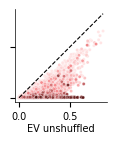

In [15]:
area='L4'
palette=v1_cmap

fontsize=7
line_color='black'
x= 'EV'
y='EV shuffled'
hue='EV gray screen'

fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area],
x=x, y=y, hue=hue, palette=palette, s=5)

ev_max = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].max()
ev_shuffled_max= df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].max()
ev_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].min()
ev_shuffled_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].min()

legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylabel(None)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':fontsize*0.8})
legend.get_frame().set_linewidth(0.2)

ax.plot([0, max(ev_max,ev_shuffled_max)], [0,max(ev_max, ev_shuffled_max)],color=line_color, linestyle='--', linewidth=0.8)
ax.spines[:].set_linewidth(0.5)
sns.despine()
ax.legend_.remove()
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5], labels=[])
plt.show()

## Monkey Shuffle Trial Repeats

### coding

In [16]:

all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}

In [ ]:

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)
get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25)

store_macaque_alphas(main_dir, monkey_stats, verbose=True)
get_evar_monkey_all_dates(monkey_stats)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)

In [21]:

start_time = time.time()

dates = monkey_stats['SNR'].keys()
frames_to_reduce=5
n_splits=10
area='V4'
area2='V1'
w_size=25

sample_size = 500
monkey_alphas=monkey_stats['monkey_alphas'][sample_size]
alpha = monkey_alphas[area]
alpha2=monkey_alphas[area2]
for condition_type in ['SNR','SNR_spont']:
    for date in monkey_stats[condition_type]:
        get_condition_type = get_get_condition_type(condition_type)
        resp_V4_shuffled, resp_V1=get_resps(condition_type=get_condition_type, date=date, shuffle=True,
                                    w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type])
        _, evars = get_predictions_evars_parallel(resp_V1, resp_V4_shuffled, n_splits=n_splits,
                                        frames_reduced=frames_to_reduce, alpha=alpha)
        _, evars2 = get_predictions_evars_parallel(resp_V4_shuffled, resp_V1, n_splits=n_splits,
                                        frames_reduced=frames_to_reduce, alpha=alpha2)
        
        monkey_stats[condition_type][date][area]['evar_shuffled_istims']=evars
        monkey_stats[condition_type][date][area2]['evar_shuffled_istims']=evars2
    
    print(condition_type, 'done')
end_time = time.time()
# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60
print(f'yay! date {date} for {condition_type} is completed')
print(f'Took {elapsed_time:.4f} minutes to complete') 

SNR done
SNR_spont done
yay! date 250717 for SNR_spont is completed
Took 0.3158 minutes to complete


In [29]:
## for RF data 
for condition_type in ['RF_thin','RF_large','RF_thin_spont', 'RF_large_spont']: #also 'RF_large','RF_thin'
    for date in monkey_stats[condition_type]:
        resp_V4, resp_V1, cond_labels =get_resps(condition_type=get_get_condition_type(condition_type), date=date, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type], get_RF_labels=True)
        if 'spont' in condition_type:
            chunk_size = int(300/25)
        else:
            chunk_size = None
        binned_epochs = get_img_resp_avg_sem(resp_V4, date, condition_type=get_get_condition_type(condition_type), chunk_size=chunk_size, get_chunks=True)
        binned_labels = cond_labels[:,0,0]
        shuffled_labels = trial_randomize(binned_labels, seed=None)
        shuffled_resp_V4 = binned_epochs[shuffled_labels].reshape(-1, binned_epochs.shape[2])
        _, shuffled_evars = get_predictions_evars_parallel(resp_V1, shuffled_resp_V4, n_splits=10,frames_reduced=all_frames_reduced[condition_type],alpha=alpha)
        _, shuffled_evars2 = get_predictions_evars_parallel(shuffled_resp_V4, resp_V1, n_splits=10,frames_reduced=all_frames_reduced[condition_type], alpha=alpha2)

        monkey_stats[condition_type][date][area]['evar_shuffled_istims']=shuffled_evars
        monkey_stats[condition_type][date][area2]['evar_shuffled_istims']=shuffled_evars2

### plotting

In [31]:
df_ = make_monkey_df_time(monkey_stats)
df = df_[(df_['SNR']>2)&(df_['split-half r']>0.8)]
melted_df = df.melt(id_vars=['Date', 'Area','Activity Type'], 
                    value_vars=['EV', 'EV shuffled', 'control shuffle EV'], 
                    var_name='Analysis Type', 
                    value_name='Value')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


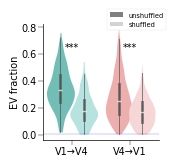

In [33]:
fontsize=7
areas = ['V4','V1']
fig, ax = plt.subplots(figsize=(1.5,1.5))
sns.violinplot(data=melted_df, x='Area', y='Value', 
            hue='Analysis Type', order=['V4', 'V1'],hue_order=['EV', 'EV shuffled'],
            linewidth=0, gap=-0.2, width=0.8, inner='box', palette=['gray','lightgray'],
            inner_kws={'box_width':2, 'alpha':0.7, 'markersize':3, 'markeredgewidth':1},
            saturation=1,cut=0)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=handles, labels=['unshuffled', 'shuffled'], fontsize=6*0.8, loc=(0.55,0.95))
legend.get_frame().set_linewidth(0.2)
xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticks(ticks=ax.get_xticks(), labels=['V1→V4', 'V4→V1'], fontsize=6)
ax.set_ylabel('EV fraction', fontsize=fontsize, labelpad=1)
ax.set(xlabel=None)
ax.tick_params(axis='both', labelsize=fontsize, pad=1, width=0.3)
sns.despine()
custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE', '#f6d6d6']
violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
for violin, color in zip(violins, custom_colors):
    violin.set_facecolor(color)
ax.spines[:].set_linewidth(0.5)
add_stars_2_sets(melted_df[melted_df['Analysis Type'].isin(['EV', 'EV shuffled'])], neuron_property='Value',
hue='Analysis Type', ax=ax, fontsize=fontsize, x='Area', x_order=['V4', 'V1'],height1=0.8, height2=0.8, perm_type='paired')
plot_null_line(df, neuron_property='control shuffle EV', ax=ax)
plt.savefig(fig_dir + 'fig7d_monkey_shuffle_trial_ev.eps', transparent=True, bbox_inches='tight')
plt.show()

In [34]:
df_ = make_monkey_df_time(monkey_stats)
df_spont=make_monkey_df_time(monkey_stats, dataset_types=['SNR_spont','RF_thin_spont','RF_large_spont'])
df_spont_ =df_spont.rename(columns={'Activity Type':'Activity Type spont','EV':'EV gray screen', 'EV shuffled':'EV shuffled gray screen','Max Corr Vals':'Max Corr Val Spont','null_shuffled': 'null_shuffled spont',
'Coeff Val':'Coeff Val spont'})               
df_both = pd.merge(df_, df_spont_, on=['Date', 'Area', 'SNR', 'split-half r','1-vs-rest r²'])
df_both_sorted = df_both.sort_values('EV gray screen')

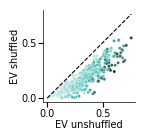

In [35]:
fontsize=7
area='V4'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV gray screen', palette=v4_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.legend_.remove()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
plt.savefig(fig_dir + 'fig7_monkey_all_shuffled_vs_unshuffled_V4.eps', transparent=True, bbox_inches='tight')
plt.show()


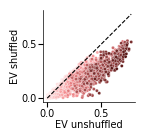

In [36]:
fontsize=7
area='V1'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV gray screen', palette=v1_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.legend_.remove()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
plt.savefig(fig_dir + 'fig7_monkey_all_shuffled_vs_unshuffled_V1.eps', transparent=True, bbox_inches='tight')
plt.show()


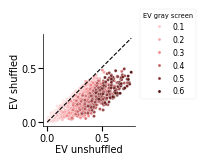

In [42]:
fontsize=7
area='V1'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV gray screen', palette=v1_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
# ax.legend_.remove()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
# plt.savefig(fig_dir + 'fig7_monkey_all_shuffled_vs_unshuffled_V1.eps', transparent=True, bbox_inches='tight')
plt.show()


### supplemental

In [37]:
df_ = make_monkey_df_time(monkey_stats, dataset_types=['SNR_spont','RF_thin_spont','RF_large_spont'])
df = df_[(df_['SNR']>2)&(df_['split-half r']>0.8)]
melted_df = df.melt(id_vars=['Date', 'Area','Activity Type'], 
                    value_vars=['EV', 'EV shuffled', 'control shuffle EV'], 
                    var_name='Analysis Type', 
                    value_name='Value')

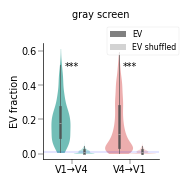

In [38]:
fontsize=7
areas = ['V4','V1']
fig, ax = plt.subplots(figsize=(1.5,1.5))
sns.violinplot(data=melted_df, x='Area', y='Value', 
            hue='Analysis Type', order=['V4', 'V1'],hue_order=['EV', 'EV shuffled'],
            linewidth=0, gap=-0.2, width=0.8, inner='box', palette=['gray','lightgray'],
            inner_kws={'box_width':2, 'alpha':0.7},
            saturation=1,cut=0)
legend = ax.legend(fontsize=fontsize*0.8, loc=(0.55,0.9))
legend.get_frame().set_linewidth(0.2)
xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticks(ticks=ax.get_xticks(), labels=['V1→V4', 'V4→V1'], fontsize=6)
ax.set_ylabel('EV fraction', fontsize=fontsize, labelpad=1)
ax.set(xlabel=None)
ax.tick_params(axis='both', labelsize=fontsize, pad=1, width=0.3)
sns.despine()
custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE', '#f6d6d6']
violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
for violin, color in zip(violins, custom_colors):
    violin.set_facecolor(color)
ax.spines[:].set_linewidth(0.5)
add_stars_2_sets(melted_df[melted_df['Analysis Type'].isin(['EV', 'EV shuffled'])], neuron_property='Value',
hue='Analysis Type', ax=ax, fontsize=fontsize, x='Area', x_order=['V4', 'V1'],height1=0.8, height2=0.8, perm_type='paired')
plot_null_line(df, neuron_property='control shuffle EV', ax=ax)
ax.set_title('gray screen', fontsize=fontsize, x=0.5, y=1.15)
plt.show()

In [43]:
df = make_monkey_df_time(monkey_stats)
df_spont_=make_monkey_df_time(monkey_stats, dataset_types=['SNR_spont','RF_thin_spont','RF_large_spont'])
df_ =df.rename(columns={'Activity Type':'Activity Type stimulus','EV':'EV stimulus', 'EV shuffled':'EV shuffled stimulus','Max Corr Vals':'Max Corr Val stim','null_shuffled': 'null_shuffled stim',
'Coeff Val':'Coeff Val stim'})               
df_both = pd.merge(df_, df_spont_, on=['Date', 'Area', 'SNR', 'split-half r','1-vs-rest r²'])
df_both_sorted = df_both.sort_values('EV stimulus')

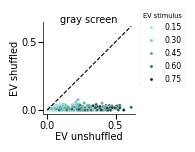

In [44]:
fontsize=7
area='V4'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV stimulus', palette=v4_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV stimulus',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
ax.set_title('gray screen', fontsize=fontsize, x=0.5, y=0.9)
plt.show()


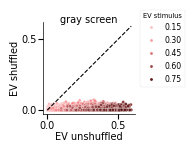

In [45]:
fontsize=7
area='V1'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV stimulus', palette=v1_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV stimulus',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
ax.set_title('gray screen', fontsize=fontsize, x=0.5, y=0.9)
plt.show()


## Monkey timewindows offset

In [ ]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates,get_max_corr_vals_monkey_all_dates,get_evar_monkey_all_dates,get_one_vs_rest_r_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)
get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25)

get_evar_monkey_all_dates(monkey_stats)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)
store_V1_indices(monkey_stats)

In [ ]:
ref_duration = 200
w_size=25
ref_area = 'V4'

condition_types = ['SNR','SNR_spont']
for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        process_timelag_shenanigans(condition_type, date, ref_area, ref_duration, 
                                monkey_stats, w_size, control_neurons=True)

In [ ]:
ref_area = 'V1'

condition_types = ['SNR','SNR_spont']
for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        process_timelag_shenanigans(condition_type, date, ref_area, ref_duration, 
                                monkey_stats, w_size, control_neurons=True)

### plotting

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Define your custom colormap colors (e.g., dark blue to light blue)
colors = ['white', '#55C0B7', '#054C47']
# Normalize the colormap between 0 and 1 (adjust as needed for your data)
norm = Normalize(vmin=0, vmax=1)
# Create the custom colormap
v4_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)


ref_area='V4'
ref_duration=200
w_size=25
condition_type='SNR'
ref_ons, ref_offs = get_refons_refoffs(ref_duration, w_size, condition_type)
df_v4_ = make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)




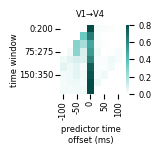

In [30]:

df_v4 = df_v4_[df_v4_['Offset(ms)'].isin([   0,   25,   50,   75,  100, -25,  -50,
        -75, -100])]
max_value_indices = df_v4.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v4.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v4.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v4.Ref_Times.unique())


fig, ax = plt.subplots(figsize=(1,0.9))

sns.heatmap(data, cmap=v4_cmap, vmin=0, vmax=0.8)
ax.tick_params(axis='both', labelsize=6, pad=1)
ax.set_ylabel('time window', fontsize=6, labelpad=0)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)

# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}', fontsize=6)
plt.show()

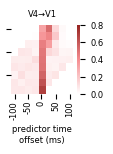

In [35]:
colors = ['white', '#F58B8E', '#94221F']
# Create the custom colormap
v1_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

ref_area='V1'
ref_duration=200
w_size=25
condition_type='SNR'
ref_ons, ref_offs = get_refons_refoffs(ref_duration, w_size, condition_type)
df_v1_ = make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)


df_v1 = df_v1_[df_v1_['Offset(ms)'].isin([   0,   25,   50,   75,  100, -25,  -50,
        -75, -100])]
max_value_indices = df_v1.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v1.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v1.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v1.Ref_Times.unique())

fig, ax = plt.subplots(figsize=(1,0.9))
sns.heatmap(data, cmap=v1_cmap, vmin=0,vmax=0.8)
ax.tick_params(axis='both', labelsize=6, pad=1)
ax.set_ylabel(None)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)
# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
ax.set_yticklabels('')

if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}', fontsize=6)
plt.show()

### supplemental

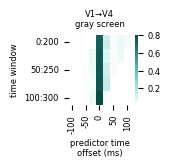

In [36]:
ref_area='V4'
fig, ax = plt.subplots(figsize=(1,0.9))

condition_type='SNR_spont'
ref_ons, ref_offs = get_refons_refoffs(ref_duration, w_size, condition_type)


df_v4= make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)
max_value_indices = df_v4.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v4.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v4.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v4.Ref_Times.unique())
sns.heatmap(data, cmap=v4_cmap, vmax=0.8)
ax.tick_params(axis='both', labelsize=6)
ax.set_ylabel('time window', fontsize=6)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)
# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}\ngray screen', fontsize=6)
plt.show()

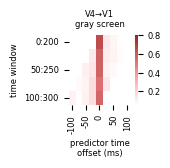

In [37]:
ref_area='V1'
fig, ax = plt.subplots(figsize=(1,0.9))
df_v1= make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)

max_value_indices = df_v1.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v1.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v1.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v1.Ref_Times.unique())
sns.heatmap(data, cmap=v1_cmap, vmax=0.8)
ax.tick_params(axis='both', labelsize=6)
ax.set_ylabel('time window', fontsize=6)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)
# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}\ngray screen', fontsize=6)
plt.show()

In [38]:
from joblib import Parallel, delayed
import time
from tqdm import tqdm

start_time = time.time()

condition_types=['SNR','SNR_spont','RS']
timebin=25
date = list(monkey_stats[condition_type].keys())[0]
timebins = [1, 10, 25, 50]
results = Parallel(n_jobs=7)(delayed(make_raw_data_df)(condition_type,date,timebin) for condition_type in condition_types)
df_ = pd.DataFrame([])
for data in results:
    df_2 = pd.DataFrame(data)
    df_= pd.concat([df_, df_2])
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Took {elapsed_time:.4f} minutes to complete')

Took 0.3060 minutes to complete


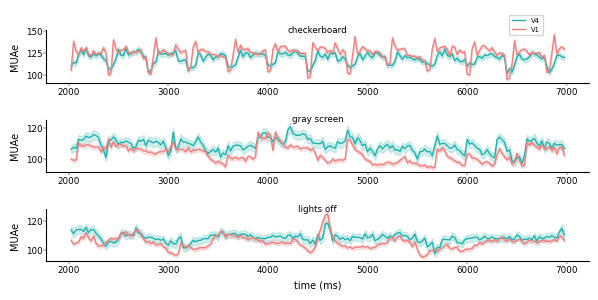

In [39]:
condition_type='SNR'
n_rows = 3
n_columns = 1
fontsize=7
reduce_factor=1
fig, axes = plt.subplots(n_rows,n_columns, figsize=(n_columns*7*reduce_factor, n_rows*reduce_factor))
for a, (ax, condition_type) in enumerate(zip(axes.flatten(), condition_types)):
    
    sns.lineplot(data=df_[(df_['time']>2000)&(df_['time']<7000)&(df_['timebin']==timebin)&(df_['Dataset_Type']==condition_type)], 
            x='time',y='MUAe', hue='Area', ax=ax, errorbar='se', 
            palette=['lightseagreen','lightcoral'], linewidth=1)
    if 'spont' in condition_type:
        cond_label = 'gray screen'
    elif 'RS' in condition_type:
        cond_label = 'lights off'
    elif 'SNR' in condition_type:
        cond_label = 'checkerboard'
    else:
        cond_label = 'unknown'
    ax.set_title(f'{cond_label}', y=0.8, fontsize=fontsize*.9)
    ax.legend_.remove()
    ax.xaxis.get_label().set_fontsize(fontsize)
    ax.yaxis.get_label().set_fontsize(fontsize)
    ax.tick_params(axis='both', labelsize=fontsize*.9, width=0.3, length=2, pad=1)

    if a!=2:
        ax.set_xlabel(None)
    else:
        ax.set_xlabel('time (ms)')
    sns.despine()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85,0.88), fontsize=fontsize*0.7)
fig.subplots_adjust(hspace=1)
# fig.suptitle(f'{condition_type} {date}',x=0.5,y=1, fontsize=fontsize)
plt.subplots_adjust(wspace=0.15,hspace=0.7)

